In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from collections import Counter
import warnings
import os
warnings.simplefilter(action='ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
import time
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
# Read the data
df = pd.read_csv("ex4_data.csv") 

#Let's look at our data before cleaning it:
df

,INTENSIVE,NEWSITEID,RISK10YRS,INCLUSIONFRS,SBP,DBP,N_AGENTS,NOAGENTS,SMOKE_3CAT,ASPIRIN,EGFR,SCREAT,SUB_CKD,RACE_BLACK,AGE,FEMALE,SUB_CVD,SUB_CLINICALCVD,SUB_SUBCLINICALCVD,SUB_SENIOR,RACE4,CHR,GLUR,HDL,TRR,UMALCR,BMI,STATIN,SBPTERTILE,EVENT_PRIMARY
0,Regular,74.0,29.732061,True,145,80,2,False,3,True,67.69,1.11,False,False,60,False,True,True,False,False,WHITE,155,81,36,92,5.80,33.115201,True,3,False
1,Regular,8.0,29.677619,True,138,71,1,False,2,True,60.64,1.17,False,False,75,False,False,False,False,True,WHITE,243,107,61,188,5.45,28.842380,True,2,False
2,Intensive,25.0,17.443819,True,143,92,2,False,2,False,68.44,1.09,False,False,62,False,False,False,False,False,WHITE,180,116,47,125,13.33,33.643060,False,2,False
3,Regular,96.0,8.627849,False,123,68,2,False,1,False,71.94,0.78,False,False,75,True,False,False,False,True,WHITE,234,93,89,109,6.12,29.337871,False,1,False
4,Intensive,42.0,23.751437,True,126,51,2,False,2,False,50.19,1.36,True,False,81,False,False,False,False,True,WHITE,126,108,39,84,28.78,36.660286,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8741,Regular,102.0,10.896486,False,138,59,2,False,2,True,79.57,0.71,False,False,78,True,False,False,False,True,WHITE,199,90,85,74,12.73,27.186534,True,2,False
8742,Regular,98.0,8.646088,False,119,73,3,False,2,False,22.60,2.08,True,False,85,True,False,False,False,True,WHITE,145,83,52,95,440.38,42.191997,True,1,False
8743,Regular,99.0,24.191491,True,137,75,0,True,2,False,74.74,1.00,False,False,66,False,True,True,False,False,WHITE,167,80,46,75,26.92,19.462021,True,2,False
8744,Intensive,15.0,20.354619,True,154,93,0,True,2,True,32.32,1.64,True,False,56,True,False,False,False,False,WHITE,245,103,37,369,3.20,35.579436,False,3,False


In [ ]:
#Preprocesing - Cleaning the data - remove null values
#First let's check if there are some null values in our received data
print(df.isnull().values.any())

#As we can see, there are null values. Now we will check what are the columns containing these values:
print("The columns containing NULL values are:", df.columns[df.isnull().any()].tolist())

#We can see that the column "NewSiteID" contains null - since the columns values are not numeric, let's check the percentage of missing values in it:
print("The percentage of missing values in NewSiteID out of the whole df: ", df[df.columns[df.isnull().any()].tolist()[0]].isna().sum()/len(df))

#As we can see it's not significant so let's drop the null values:
nonull_df = df.dropna()

True
The columns containing NULL values are: ['NEWSITEID']
The percentage of missing values in NewSiteID out of the whole df:  0.05316716213126001


In [ ]:
#Preprocesing - Cleaning the data - convert the columns to numeric columns 
# Convert non-numeric features to numeric features
nonull_df["INTENSIVE"] = nonull_df["INTENSIVE"].astype('category')
nonull_df["INTENSIVE"] = nonull_df["INTENSIVE"].cat.codes

# Using dummy variables on "RACE4"
numeric_df = pd.concat([nonull_df,pd.get_dummies(nonull_df['RACE4'], prefix = 'RACE4')], axis=1) 
numeric_df.drop(['RACE4'], axis=1, inplace=True) 

#Now we can see that there are two columns "RACE4_BLACK" and "RACE_BLACK", let's check the correlation between them:
if numeric_df['RACE4_BLACK'].corr(numeric_df['RACE_BLACK'])>0.80:
    numeric_df.drop(['RACE_BLACK'], axis=1, inplace=True)

In [ ]:
#Now let's look at our data after the cleaning part:
numeric_df

,INTENSIVE,NEWSITEID,RISK10YRS,INCLUSIONFRS,SBP,DBP,N_AGENTS,NOAGENTS,SMOKE_3CAT,ASPIRIN,EGFR,SCREAT,SUB_CKD,AGE,FEMALE,SUB_CVD,SUB_CLINICALCVD,SUB_SUBCLINICALCVD,SUB_SENIOR,CHR,GLUR,HDL,TRR,UMALCR,BMI,STATIN,SBPTERTILE,EVENT_PRIMARY,RACE4_BLACK,RACE4_HISPANIC,RACE4_OTHER,RACE4_WHITE
0,1,74.0,29.732061,True,145,80,2,False,3,True,67.69,1.11,False,60,False,True,True,False,False,155,81,36,92,5.80,33.115201,True,3,False,0,0,0,1
1,1,8.0,29.677619,True,138,71,1,False,2,True,60.64,1.17,False,75,False,False,False,False,True,243,107,61,188,5.45,28.842380,True,2,False,0,0,0,1
2,0,25.0,17.443819,True,143,92,2,False,2,False,68.44,1.09,False,62,False,False,False,False,False,180,116,47,125,13.33,33.643060,False,2,False,0,0,0,1
3,1,96.0,8.627849,False,123,68,2,False,1,False,71.94,0.78,False,75,True,False,False,False,True,234,93,89,109,6.12,29.337871,False,1,False,0,0,0,1
4,0,42.0,23.751437,True,126,51,2,False,2,False,50.19,1.36,True,81,False,False,False,False,True,126,108,39,84,28.78,36.660286,False,1,False,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8741,1,102.0,10.896486,False,138,59,2,False,2,True,79.57,0.71,False,78,True,False,False,False,True,199,90,85,74,12.73,27.186534,True,2,False,0,0,0,1
8742,1,98.0,8.646088,False,119,73,3,False,2,False,22.60,2.08,True,85,True,False,False,False,True,145,83,52,95,440.38,42.191997,True,1,False,0,0,0,1
8743,1,99.0,24.191491,True,137,75,0,True,2,False,74.74,1.00,False,66,False,True,True,False,False,167,80,46,75,26.92,19.462021,True,2,False,0,0,0,1
8744,0,15.0,20.354619,True,154,93,0,True,2,True,32.32,1.64,True,56,True,False,False,False,False,245,103,37,369,3.20,35.579436,False,3,False,0,0,0,1


In [ ]:
#Split into train and test - 20% test size, 80% train size 
#Remove the labels from the train part (no need)
y = numeric_df["EVENT_PRIMARY"]
X = numeric_df.drop(columns=["EVENT_PRIMARY"])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
# First Model - Logistic regression
grid = {"clf__C":np.logspace(-3,3,7), "clf__penalty":["l1","l2"], "clf__max_iter": [5000, 15000, 20000, 40000]}
logreg=LogisticRegression()
scaler = StandardScaler()
model = Pipeline([
        ('standard', scaler),
        ('sampling', SMOTE()),
        ('clf', logreg)
    ])

# Hyper tuning parmeters and choosing the best parameters
logregCV = GridSearchCV(model,grid,scoring='accuracy',cv=3)
logregCV.fit(X_train,y_train)
logreg_params = logregCV.best_params_
logRegModel = logregCV.best_estimator_

In [ ]:
print("The best parameters of the Logistic Regression model are:", logreg_params)

The best parameters of the Logistic Regression model are: {'clf__C': 0.1, 'clf__max_iter': 5000, 'clf__penalty': 'l2'}


In [ ]:
pred_test = logRegModel.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, pred_test))

pred_train = logRegModel.predict(X_train)
print("Train accuracy:", accuracy_score(y_train, pred_train))


Test accuracy: 0.695835847917924
Train accuracy: 0.6730072463768116


## Answer for the question - Does the model overfit?

As we can see, the difference between the accuracy score of the train data and the accuracy score of the test data if about 0.02, which is NOT indicate  overfit. We did not axpected to see overfit thanks to the fact that we used parameters that prevent overfit such as GRID search and Cross Validation.

In [ ]:
# Second model - Random Forest 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()

# Hyper tuning parmeters
param_grid = {
    'clf__bootstrap': [True],
    'clf__max_depth': [90, 110],
    'clf__max_features': [10, 20],
    'clf__min_samples_leaf': [4, 5],
    'clf__min_samples_split': [10, 15],
    'clf__n_estimators': [300, 1000]
}

rf = RandomForestClassifier()

# add pipeline
model = Pipeline([
        ('standard', scaler),
        ('sampling', SMOTE()),
        ('clf', rf)
    ])

search = GridSearchCV(estimator = model, param_grid = param_grid, scoring='accuracy', cv = 3, n_jobs = -1, verbose = 2)
search.fit(X_train,y_train)
RF_best_params = search.best_params_
rfModel = search.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [ ]:
print("The best parameters of the Random Forest model are:", RF_best_params)

The best parameters of the Random Forest model are: {'clf__bootstrap': True, 'clf__max_depth': 110, 'clf__max_features': 20, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}


In [ ]:
# choose the best parameters and the best model, as examined in the gridsearch procedure

estimators_num = [20, 50, 100, 200, 500, 1000]
scaler = StandardScaler()
accs_test = []
accs_train = []

bootstrap = RF_best_params['clf__bootstrap']
max_depth = RF_best_params['clf__max_depth']
max_features = RF_best_params['clf__max_features']
min_samples_leaf = RF_best_params['clf__min_samples_leaf']
min_samples_split = RF_best_params['clf__min_samples_split']
  
for est in estimators_num:
  RFModel_est = RandomForestClassifier(bootstrap=bootstrap, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=est)
  model = Pipeline([
        ('standard', scaler),
        ('sampling', SMOTE()),
        ('clf', RFModel_est)
    ])
  fit_RFModel = model.fit(X_train, y_train)
  pred_test = fit_RFModel.predict(X_test)
  pred_train = fit_RFModel.predict(X_train)
  accs_test.append(accuracy_score(y_test, pred_test))
  accs_train.append(accuracy_score(y_train, pred_train))


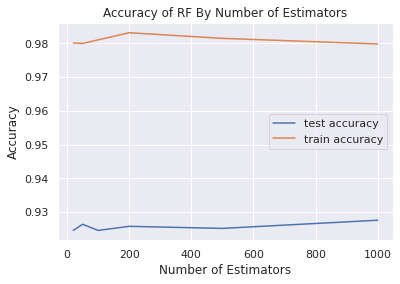

In [ ]:
plt.plot(estimators_num, accs_test, label = "test accuracy")
plt.plot(estimators_num, accs_train, label = "train accuracy")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy of RF By Number of Estimators")
plt.legend()
plt.show()

##Does the model overfit?
As we can see, the range of the accuracy scores for the train data is around the value of 0.98, while the accuracy score for the test data is between approximately 0.93 to 0.945. Even tho the accuracy of the train is bigger than the accuracy of the test, we can notice that difference is very small(around 0.05) and that the accuracies are both around the value of 0.9. Therefore, we can claim that there is no overfit for this model.

In [ ]:
# Third Model - ANN
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import neural_network
from imblearn.pipeline import Pipeline
scaler = StandardScaler()
model = Pipeline([
        ('standard', scaler),
        ('sampling', SMOTE()),
        ('clf', neural_network.MLPClassifier())
    ])

# Multi-layer Perceptron is sensitive to feature scaling, so it is important to scale our data
parameters = {'clf__solver': ['adam'], 'clf__max_iter': [500], 'clf__alpha': 10.0 ** -np.arange(1, 4), 'clf__hidden_layer_sizes':[6, 20], 'clf__random_state':[0,1]}
gs_nn = GridSearchCV(model, parameters, n_jobs=-1,cv=3)
gs_nn.fit(X_train, y_train)
ann_best_params = gs_nn.best_params_
annModel = gs_nn.best_estimator_

In [ ]:
print("The best parameters of the ANN model are:", ann_best_params)

The best parameters of the ANN model are: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': 20, 'clf__max_iter': 500, 'clf__random_state': 1, 'clf__solver': 'adam'}


No handles with labels found to put in legend.


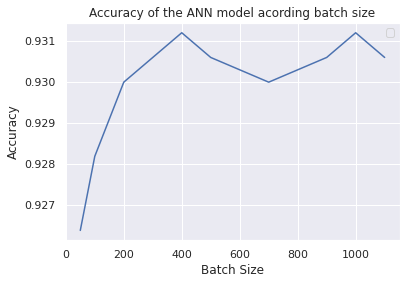

In [ ]:
# choose the best parameters and the best model, as examined in the gridsearch procedure

batch_sizes = [50, 100, 200, 400, 500, 700, 900, 1000, 1100]
accs_test = []
scaler = StandardScaler()
accs_train = []

solver = ann_best_params['clf__solver']
max_iter = ann_best_params['clf__max_iter']
alpha = ann_best_params['clf__alpha']
hidden_size = ann_best_params['clf__hidden_layer_sizes']
rand_state = ann_best_params['clf__random_state']

for batch_size in batch_sizes:
  annModel_batch = neural_network.MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=(hidden_size, ), random_state=rand_state, batch_size=batch_size)
  model = Pipeline([
        ('standard', scaler),
        ('clf', annModel_batch)
    ])
  fit_annModel = model.fit(X_train, y_train)
  pred_test = fit_annModel.predict(X_test)
  pred_train = fit_annModel.predict(X_train)
  accs_test.append(accuracy_score(y_test, pred_test))
  accs_train.append(accuracy_score(y_train, pred_train))

plt.plot(batch_sizes, accs_test)
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy of the ANN model acording batch size")
plt.legend()
plt.show()

## What is the effect of the batch size?

We can see that the general trend is that as the batch size increases, the accuracy also mostly increases. We can notice some declines, but it's negligible. 

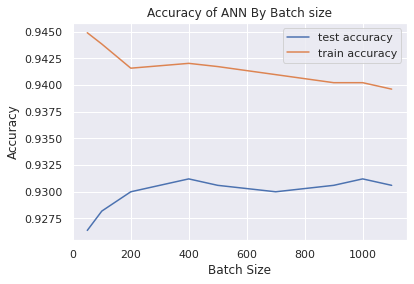

In [ ]:
plt.plot(batch_sizes, accs_test, label = "test accuracy")
plt.plot(batch_sizes, accs_train, label = "train accuracy")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy of ANN By Batch size")
plt.legend()
plt.show()

## Does the model overfit?
As we can see, the range of the accuracy scores for the test data is between approximately 0.9275 to 0.93, while the range of the accuracy scores for the train data is between approximately 0.94 to 0.945. We can see that the accuracies are both around the value of 0.9. this insight indicated that the difference between the accuracies of the test and train is negligible so we can claim that there is no overfit for this model.

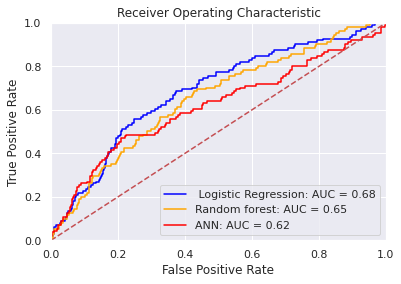

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import roc_curve, roc_auc_score
import sklearn.metrics as metrics

# Set all the classifiers we trained and hyper tuned earlier
classifiers = []
classifiers.append(logRegModel)
classifiers.append(rfModel)
classifiers.append(annModel)
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# calculate the fpr and tpr for all thresholds of the classification
probs = logRegModel.predict_proba(X_test)
preds = probs[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_test, preds)
roc_auc1 = metrics.auc(fpr1, tpr1)

probs = rfModel.predict_proba(X_test)
preds = probs[:,1]
fpr2, tpr2, threshold = metrics.roc_curve(y_test, preds)
roc_auc2 = metrics.auc(fpr2, tpr2)

probs = annModel.predict_proba(X_test)
preds = probs[:,1]
fpr3, tpr3, threshold = metrics.roc_curve(y_test, preds)
roc_auc3 = metrics.auc(fpr3, tpr3)

# Plot the graph
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = ' Logistic Regression: AUC = %0.2f' % roc_auc1, color='blue')
plt.plot(fpr2, tpr2, 'b', label = 'Random forest: AUC = %0.2f' % roc_auc2, color ='orange')
plt.plot(fpr3, tpr3, 'b', label = 'ANN: AUC = %0.2f' % roc_auc3, color ='red')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Who is the best model?
In order to compare between the models we decided to use the ROC Curce method that we learnes in class. 
As we can see in the ROC and AUC results, the model Logistic Regression has the best prediction with AUC score of 0.68. After that, the Random Forest classifier with AUC score of 0.65, and finally the ANN model with AUC score of 0.62.

##Preprocessing and cleaning the data - 
1. Removing Null Values - We checked if there are null values in our received dataset. We noticed that the column "newsiteID" contains null values. The type of this column is not numeric so it might be a problem to use the known methods for missing values. Therefore, we checked the percentage of missing values, we saw that the percentage is very negliable so we decided to remove the null values. 

2. Convert non-numeric features to numeric features - for a multicategorial feature, such as "RACE4" we used "dummy variables". After this process, we noticed that there are 2 columns - "RACE_4BLACK" and "RACE_BLACK" - so checked the correlation betweem, since the correlation was high - we removed one of them, since its not efficient. 

## Why we chose each model?
For the linear model: We chose Logistic Regression. We chose it because this model performs prediction when the dependent variable is binary and not numeric.

For the Ensemble model: We chose Random Forest classifier since it offers efficient estimates of the test error without incurring the cost of repeated model training associated with cross-validtion. It is also notvery affected by noise.

For the Deep Learning model: We chose ANN, because our data contain features from different types.

##Pipeline for each model:
We created a pipeline for each model - the first step is to normalize the data. The seccond step is to use Resampling method with the "Smoth" object - we decided to do that since our data is highly imbalanced (on the train data only).
The third and final step is to run the model itself.

##Creating Search Grid:
We created a search grid Cross Validation for each model - the purpose is to use hyper tuning for the parameters of the model - find the best parameters according to the Accuracy Score. This grid is also running cross validation on the data.

For each model, our final model was the one received with the best parameters from its search grid.

## Who is the best model?
In order to compare between the models we decided to use the ROC Curce method that we learnes in class. 
As we can see in the ROC and AUC results, the model Logistic Regression has the best prediction with AUC score of 0.68. After that, the Random Forest classifier with AUC score of 0.65, and finally the ANN model with AUC score of 0.62.